# First Computing of the Fitting Factor

Given a measured signal, the Fitting factor (FF) is the maximized match between the measured signal and the signals in the template bank (or its parameters). So to compute a simple example, we will create a template banck of different masses of a binary system and compare them with a simulated gravitational wave. To simplify this examen, we will set spin=0, eccentricity=0, etc for every black hole so we can restrict to optimizing the masses. After that, we will do the same computation but with nonzero third component of the spin and with fixed masses.

### Import useful Packages

In [2]:
import math
import lal
import lalsimulation as lalsim
import numpy as np
import matplotlib.pyplot as plt 
import random

from pycbc.filter import match as simple_match, optimized_match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform.utils import coalign_waveforms

/tmp/ipykernel_18271/1300312938.py:2: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


## Non-Spinning Black Hole Binary System

### We define the simulation function for nonspinning black holes

In [3]:
def simulationTD_IMRPhenomTPHM(mass1:float, mass2:float, r:float, delta_T:float, f_min:float, f_ref:float, spin1:tuple = (0,0,0), spin2:tuple = (0,0,0), inclination:float = 0, phiRef:float = 0, eccentricity:float = 0)->tuple:

    Approximant = "IMRPhenomTPHM"

    (spin1x, spin1y, spin1z) = spin1
    (spin2x, spin2y, spin2z) = spin2

    # Modes
    mode_list = [[2, 2], [2, -2]]

    # Create the waveform parameters structure
    waveform_params = lal.CreateDict()

    mode_array = lalsim.SimInspiralCreateModeArray()
    for l, m in mode_list:
        lalsim.SimInspiralModeArrayActivateMode(mode_array, l, m)
    lalsim.SimInspiralWaveformParamsInsertModeArray(waveform_params, mode_array)


    with lal.no_swig_redirect_standard_output_error():
    # Generate the waveform
        hplus, hcross = lalsim.SimInspiralChooseTDWaveform(
        mass1, mass2, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, r, inclination, phiRef, 0.0, eccentricity, 0.0,
        delta_T, f_min, f_ref, waveform_params, lalsim.GetApproximantFromString(Approximant)
        )

    # Extract time series for both plus (h_plus) and cross (h_cross) polarizations
    h_plus = hplus.data.data
    h_cross = hcross.data.data 
    time = np.arange(len(h_plus)) * delta_T

    return h_plus, h_cross, time # The data is returned as Numpy arrays, we lost information of the epoch, etc which we won't use in this example



### We define the match function for an arbitrary gravitational wave

In [4]:
def perform_match(hnr, hap, f_lower, f_high, optimized = False, return_phase = False):
    FD = isinstance(hnr, FrequencySeries)
    if not FD: 
        hnr, hap = hnr.real(), hap.real()
    
    # Match signal sizes
    length = min(len(hnr), len(hap))
    hnr.resize(length); hap.resize(length)

    # Compute PSD
    if FD: 
        delta_f = hnr.delta_f
    else:
        delta_f = 1/hnr.duration
    
    psd = aLIGOZeroDetHighPower(length, delta_f, f_lower)
    
    # Compute Match
    match_kwargs = dict(vec1 = hnr, vec2 = hap, psd = psd, low_frequency_cutoff = f_lower, high_frequency_cutoff = f_high, return_phase = return_phase)
    return optimized_match(**match_kwargs) if optimized else simple_match(**match_kwargs, subsample_interpolation = True)


### Simulation of the Target GW

We start creating the simulation of the target gravitational wave. We simulate it in the Time-Domain.

In [13]:
mass1_target = 30 * lal.MSUN_SI
mass2_target = 20 * lal.MSUN_SI
r_target = 1e6 * lal.PC_SI

spin1_target = (0.0,0.0,0.0)
spin2_target = (0.0,0.0,0.0)

delta_T_target = 1.0/4096.0 
f_min_target = 15
f_max_target = 250
f_ref_target = f_min_target

hp_target, hc_target, time_target = simulationTD_IMRPhenomTPHM(mass1_target, mass2_target, r_target, delta_T_target, f_min_target, f_ref_target, spin1_target, spin2_target)


### Creation of the Template_Bank of GW

We create a template for the analysis of the match. The only non-fixed parameters are the black hole masses, so we create a numpy array of equispaced masses betwwen 10 and 100 solar masses. One of the peculiarities of lalsimulation is that with the function that we are using we cannot simulate near 0 masses (obviously) and ratios greater than 200 (i. e. m1/m2>200 or m2/m1>200) because it would not be considered a binary system of approximately equal masses.

The parameters of the cumputing (delta_T, f_min, f_max, etc) are the same as for the target and we also fixed the distance to the source r.

In [17]:
N_template = 100

mass1_template = np.linspace(10, 199, N_template)
mass2_template = np.linspace(10, 199, N_template)
mass1_template = mass1_template * lal.MSUN_SI
mass2_template = mass2_template * lal.MSUN_SI

spin1_template = spin1_target
spin2_template = spin2_target

r_template = 1e6 * lal.PC_SI
delta_T_template = delta_T_target
f_min_template = f_min_target
f_max_template = f_max_target
f_ref_template = f_min_template

### Simulation and Comparing Matched

We simulate all the template unique conbinations and save the best one. We also plot the best match with the target GW to see the similarity.

The nearest match is 0.9818748081272827, using masses of 17.0 and 35.0 solar masses respectively


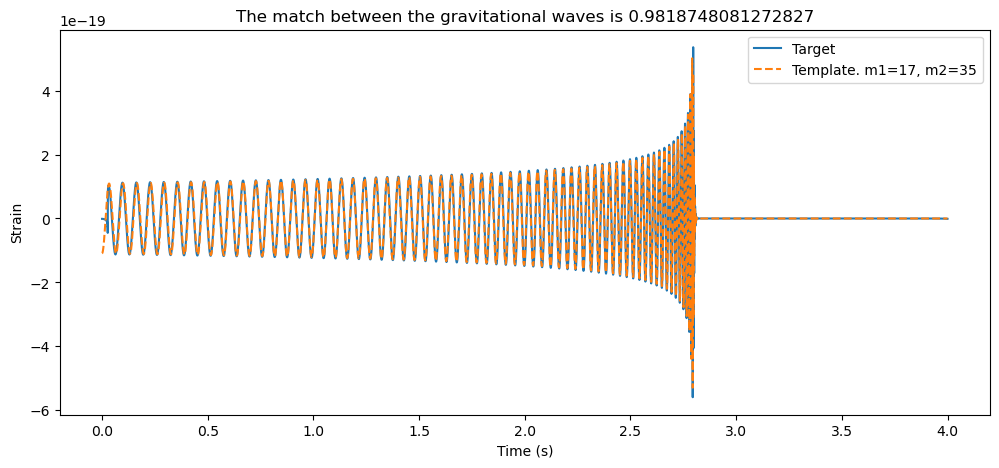

In [18]:
hp_template = []
hc_template = []
time_template = []
# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_target = TimeSeries(hp_target, delta_t=delta_T_target) 

all_match_for_plot = []
all_mass1_for_plot = []
all_mass2_for_plot = []
match = 0
for mass1 in mass1_template:
    for mass2 in mass2_template:

        if mass2 >= mass1:
            hp, hc, time = simulationTD_IMRPhenomTPHM(mass1, mass2, r_template, delta_T_template, f_min_template, f_ref_template, spin1_template, spin2_template)
            # Convert the data obtained from a numpy array to a PyCBC TimeSeries
            hp = TimeSeries(hp, delta_t=delta_T_template) 

            # Computation of the Match
            match_new, Index_new, delta_phi_new = perform_match(hp_target, hp, f_lower = f_min_template, f_high = f_max_template, return_phase = True)
            
            all_match_for_plot.append(match_new)
            all_mass1_for_plot.append(int(mass1/lal.MSUN_SI))
            all_mass2_for_plot.append(int(mass2/lal.MSUN_SI))


            if match_new > match:
                match, Index, delta_phi = match_new, Index_new, delta_phi_new
                mass1_FF = mass1
                mass2_FF = mass2
                hp_FF = hp 
                hc_FF = hc
                time_FF = time 


# Waveforms Coaligned 
h1_aligned, h2_aligned = coalign_waveforms(hp_target, hp_FF)

print(f"The nearest match is {match}, using masses of {mass1_FF/lal.MSUN_SI} and {mass2_FF/lal.MSUN_SI} solar masses respectively")

# Plot of the coaligned waveforms
plt.figure(figsize=(12, 5))
plt.plot(h1_aligned.sample_times, h1_aligned, label = f'Target')
plt.plot(h2_aligned.sample_times, h2_aligned, label = f'Template. m1={int(mass1_FF/lal.MSUN_SI)}, m2={int(mass2_FF/lal.MSUN_SI)}', linestyle='dashed')
plt.title(f'The match between the gravitational waves is {match}')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.show()

### Relationships with the match

We plot different relationships between the masses of the system and the obtained match. We plot every template we tried to see what the best matches have in common. As we expected, the parameter that a simple black hole binary system (with dependances only in the (2,2) and (2,-2) modes) is the chirp mass, defined as

$$

M_c=\frac{(m_1m_2)^{3/5}}{(m_1+m_2)^{1/5}}.

$$

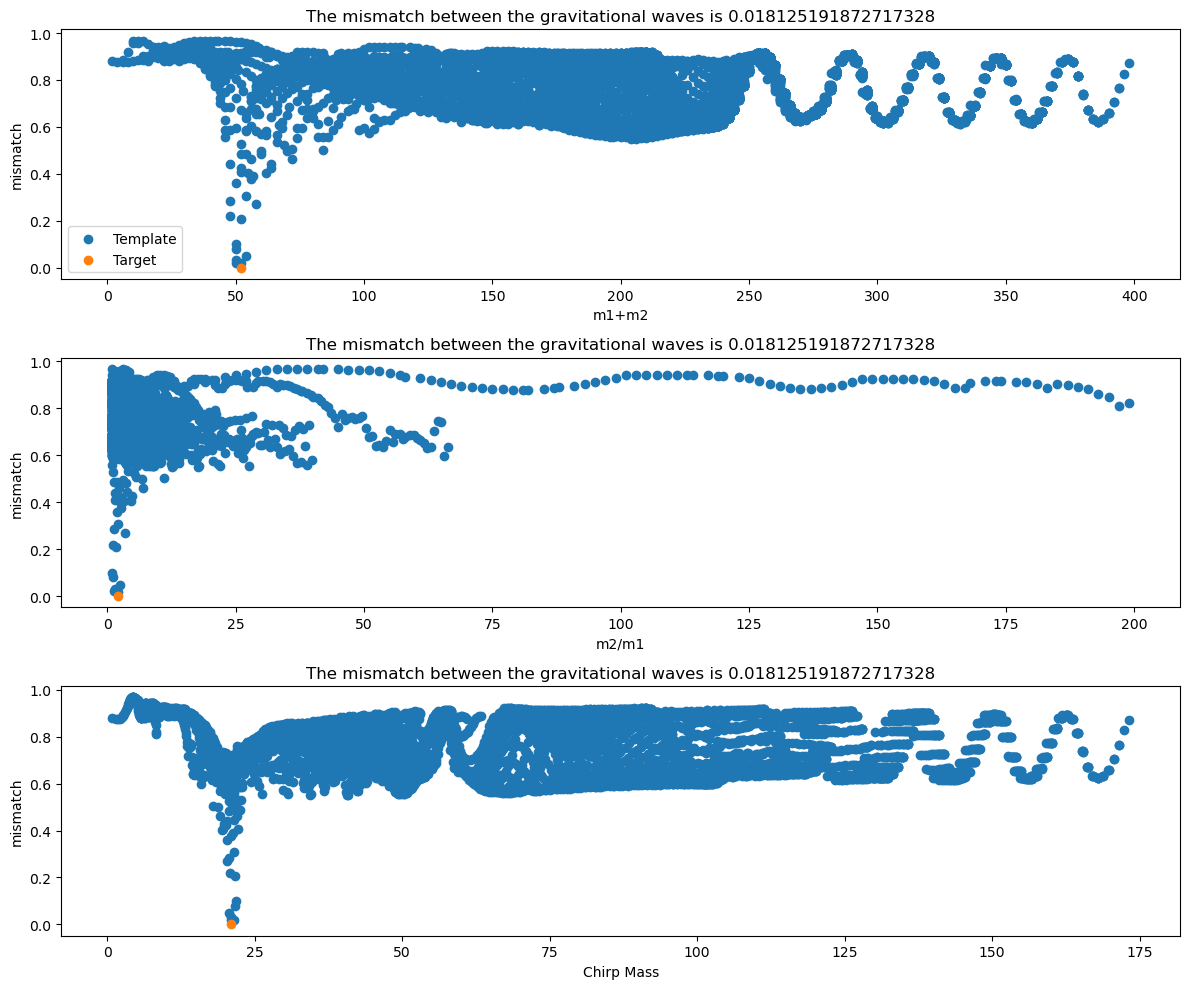

In [19]:
suma = []
division = []
chirp_mass = []
all_mismatch_for_plot = []
for n in range(len(all_mass1_for_plot)):
    suma.append(all_mass1_for_plot[n]+all_mass2_for_plot[n])
    division.append(all_mass2_for_plot[n]/all_mass1_for_plot[n])
    chirp_mass.append((all_mass1_for_plot[n]*all_mass2_for_plot[n])**(3/5)/(all_mass1_for_plot[n]+all_mass2_for_plot[n])**(1/5))
    all_mismatch_for_plot.append(1-all_match_for_plot[n])

suma = np.array(suma)
division = np.array(division)
chirp_mass = np.array(chirp_mass)
all_mismatch_for_plot = np.array(all_mismatch_for_plot)

# Plot 
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1)
plt.scatter(suma,np.array(all_mismatch_for_plot), label = f'Template')
plt.scatter((mass1_FF+mass2_FF)/lal.MSUN_SI, 0, label = f'Target')
plt.title(f'The mismatch between the gravitational waves is {1-match}')
plt.xlabel('m1+m2')
plt.ylabel('mismatch')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(division,np.array(all_mismatch_for_plot), label = f'Template')
plt.scatter(mass2_FF/mass1_FF, 0, label = f'Target')
plt.title(f'The mismatch between the gravitational waves is {1-match}')
plt.xlabel('m2/m1')
plt.ylabel('mismatch')

plt.subplot(3, 1, 3)
plt.scatter(chirp_mass,np.array(all_mismatch_for_plot), label = f'Template')
plt.scatter(((mass1_FF*mass2_FF)**(3/5)/(mass1_FF+mass2_FF)**(1/5))/lal.MSUN_SI, 0, label = f'Target')
plt.title(f'The mismatch between the gravitational waves is {1-match}')
plt.xlabel('Chirp Mass')
plt.ylabel('mismatch')

plt.tight_layout()
plt.show()

## Spin nonprecessing

We now compute the same program but for fixed masses and nonzero spin contributions. To make it easier we suppose that both black holes are spinning in the direction defined by the normal of its orbiting plane. With this restriction we ignore the precession an we only care for the rotation of each BH.

### Defining the simulation

We need to use a different approximant for the simulation as the one used before does not take spin into account. For that reason we will use IMRPhenomTPHM. In case we need a precessing approximant we can use this one too.

In [49]:
def simulationTD_IMRPhenomTPHM(mass1:float, mass2:float, r:float, delta_T:float, f_min:float, f_ref:float, spin1:tuple = (0,0,0), spin2:tuple = (0,0,0), inclination:float = 0, phiRef:float = 0, eccentricity:float = 0)->tuple:

    Approximant = "IMRPhenomTPHM"

    (spin1x, spin1y, spin1z) = spin1
    (spin2x, spin2y, spin2z) = spin2

    # Modes
    mode_list = [[2, 2], [2, -2]]

    # Create the waveform parameters structure
    waveform_params = lal.CreateDict()

    mode_array = lalsim.SimInspiralCreateModeArray()
    for l, m in mode_list:
        lalsim.SimInspiralModeArrayActivateMode(mode_array, l, m)
    lalsim.SimInspiralWaveformParamsInsertModeArray(waveform_params, mode_array)


    with lal.no_swig_redirect_standard_output_error():
    # Generate the waveform
        hplus, hcross = lalsim.SimInspiralChooseTDWaveform(
        mass1, mass2, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, r, inclination, phiRef, 0.0, eccentricity, 0.0,
        delta_T, f_min, f_ref, waveform_params, lalsim.GetApproximantFromString(Approximant)
        )

    # Extract time series for both plus (h_plus) and cross (h_cross) polarizations
    h_plus = hplus.data.data
    h_cross = hcross.data.data 
    time = np.arange(len(h_plus)) * delta_T

    return h_plus, h_cross, time # The data is returned as Numpy arrays, we lost information of the epoch, etc which we won't use in this example



### Define and simulate the target GW

In [20]:
mass1_target = 35 * lal.MSUN_SI
mass2_target = 20 * lal.MSUN_SI
r_target = 1e6 * lal.PC_SI

spin1_target = (0.0,0.0,0.9)
spin2_target = (0.0,0.0,0.9)

delta_T_target = 1.0/4096.0 
f_min_target = 15
f_max_target = 250
f_ref_target = f_min_target

hp_target, hc_target, time_target = simulationTD_IMRPhenomTPHM(mass1_target, mass2_target, r_target, delta_T_target, f_min_target, f_ref_target, spin1_target, spin2_target)

# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_target = TimeSeries(hp_target, delta_t=delta_T_target)


### Create a template

As we said before, we will fixed the masses and we will only care for the spins. Because the BHs have different masses they are not indistinguishable so we will use a lower number of template to take into account the fact that we cannot supponse a2>a1 because m2!=m1.


In [21]:
N_template = 51

mass1_template = mass1_target
mass2_template = mass2_target

r_template = 1e6 * lal.PC_SI
delta_T_template = delta_T_target
f_min_template = f_min_target
f_max_template = f_max_target
f_ref_template = f_min_template

spin1z_template = np.linspace(-1, 1, N_template)
spin2z_template = np.linspace(-1, 1, N_template)


### Simulate every unique template

The nearest match is 0.9994604724024369, using spins of 1.0 and 0.6799999999999999 respectively


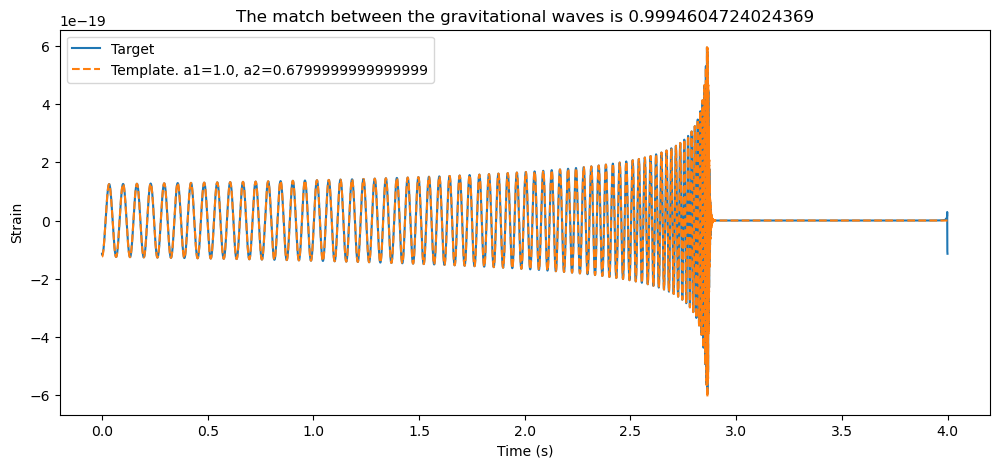

In [22]:
hp_template = []
hc_template = []
time_template = []
 
all_match_for_plot = []
all_spin1z_for_plot = []
all_spin2z_for_plot = []
match = 0
for spin1z in spin1z_template:
    for spin2z in spin2z_template:
            
        hp, hc, time = simulationTD_IMRPhenomTPHM(mass1_template, mass2_template, r_template, delta_T_template, f_min_template, f_ref_template,
                                                 (0, 0, spin1z), (0, 0, spin2z))
        # Convert the data obtained from a numpy array to a PyCBC TimeSeries
        hp = TimeSeries(hp, delta_t=delta_T_template) 

        # Computation of the Match
        match_new, Index_new, delta_phi_new = perform_match(hp_target, hp, f_lower = f_min_template, f_high = f_max_template, return_phase = True)
        
        all_match_for_plot.append(match_new)
        all_spin1z_for_plot.append(spin1z)
        all_spin2z_for_plot.append(spin2z)

        if match_new > match:
            match, Index, delta_phi = match_new, Index_new, delta_phi_new
            spin1z_FF = spin1z
            spin2z_FF = spin2z
            hp_FF = hp 
            hc_FF = hc
            time_FF = time 


# Waveforms Coaligned 
h1_aligned, h2_aligned = coalign_waveforms(hp_target, hp_FF)


print(f"The nearest match is {match}, using spins of {spin1z_FF} and {spin2z_FF} respectively")

# Plot of the coaligned waveforms
plt.figure(figsize=(12, 5))
plt.plot(h1_aligned.sample_times, h1_aligned, label = f'Target')
plt.plot(h2_aligned.sample_times, h2_aligned, label = f'Template. a1={spin1z_FF}, a2={spin2z_FF}', linestyle='dashed')
plt.title(f'The match between the gravitational waves is {match}')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.show()

### Plot the match against some quantities

We plot the match against the sum of spins (this does not make much sense as $\chi$<1), the ratio between the spins and a quatity called effective spin parameter found in some papers defined as 

$$

\chi_{eff}=\frac{\vec{\chi}_1m_1+\vec{\chi}_2m_2}{m_1+m_2}\cdot\vec{L}, \quad \text{where}\quad \vec{L}=\hat{u}_3.

$$

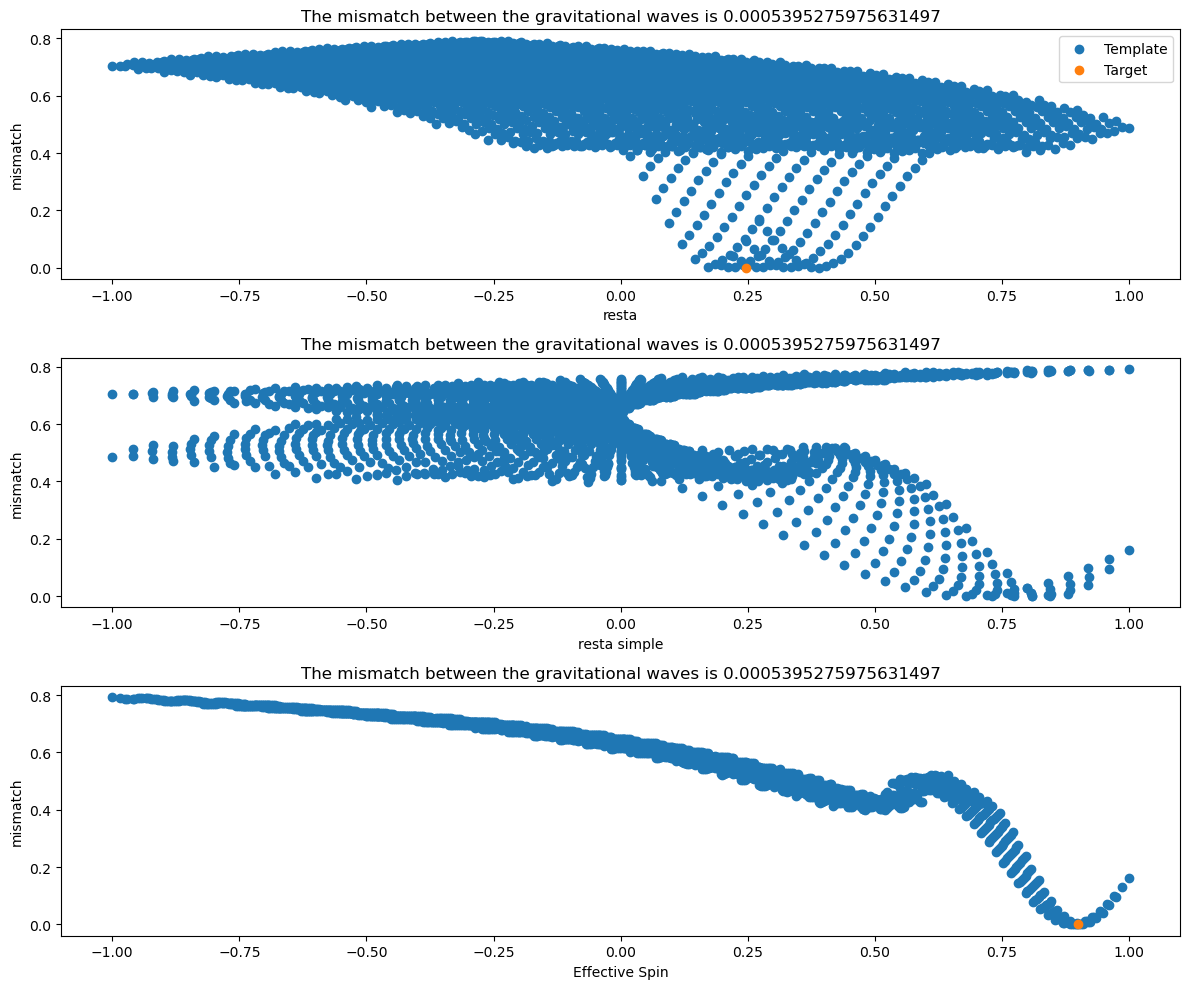

In [23]:
suma = []
eff_spin = []
resta=[]
prueba=[]
all_mismatch_for_plot = []
for n in range(len(all_spin1z_for_plot)):
    suma.append(all_spin1z_for_plot[n]+all_spin2z_for_plot[n])
    eff_spin.append(((all_spin1z_for_plot[n]*mass1_template)+(all_spin2z_for_plot[n]*mass2_template))/(mass1_template+mass2_template))
    resta.append(((all_spin1z_for_plot[n]*mass1_template)-(all_spin2z_for_plot[n]*mass2_template))/(mass1_template+mass2_template))
    prueba.append(all_spin1z_for_plot[n]*all_spin2z_for_plot[n])
    all_mismatch_for_plot.append(1-all_match_for_plot[n])

suma = np.array(suma)
eff_spin = np.array(eff_spin)
resta = np.array(resta)
prueba=np.array(prueba)
all_mismatch_for_plot = np.array(all_mismatch_for_plot)

resta_target=(((spin1_target[2]*mass1_template)-(spin2_target[2]*mass2_template))/(mass1_template+mass2_template))
prueba_target=(((spin1_target[2]*mass1_template)-(spin2_target[2]*mass2_template))/(mass1_template+mass2_template))

# Plot of the coaligned waveforms
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1)
plt.scatter(resta,np.array(all_mismatch_for_plot), label = f'Template')
plt.scatter(resta_target,0, label = f'Target')
plt.title(f'The mismatch between the gravitational waves is {1-match}')
plt.xlabel('resta')
plt.ylabel('mismatch')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(prueba,np.array(all_mismatch_for_plot), label = f'Template')
#plt.scatter(prueba_target,0, label = f'Target')
plt.title(f'The mismatch between the gravitational waves is {1-match}')
plt.xlabel('resta simple')
plt.ylabel('mismatch')

eff_spin_target=(((spin1_target[2]*mass1_template)+(spin2_target[2]*mass2_template))/(mass1_template+mass2_template))

plt.subplot(3, 1, 3)
plt.scatter(eff_spin,np.array(all_mismatch_for_plot), label = f'Template')
plt.scatter(eff_spin_target,0, label = f'Target')
plt.title(f'The mismatch between the gravitational waves is {1-match}')
plt.xlabel('Effective Spin')
plt.ylabel('mismatch')

plt.tight_layout()
plt.show()

### AHORA LA PRECESION

In [24]:
mass1_target = 100 * lal.MSUN_SI
mass2_target = 10 * lal.MSUN_SI
r_target = 1e6 * lal.PC_SI

spin1_target = (0.7,0.7,0.0)
spin2_target = (0.0,0.0,0.5)

delta_T_target = 1.0/4096.0 
f_min_target = 15
f_max_target = 250
f_ref_target = f_min_target

hp_target, hc_target, time_target = simulationTD_IMRPhenomTPHM(mass1_target, mass2_target, r_target, delta_T_target, f_min_target, f_ref_target, spin1_target, spin2_target)

# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_target = TimeSeries(hp_target, delta_t=delta_T_target)

In [26]:
N_template = 51

mass1_template = mass1_target
mass2_template = mass2_target

r_template = 1e6 * lal.PC_SI
delta_T_template = delta_T_target
f_min_template = f_min_target
f_max_template = f_max_target
f_ref_template = f_min_template

spin1x_template = np.linspace(-1, 1, N_template)
spin1y_template = np.linspace(-1, 1, N_template)

The nearest match is 0.9767480971672468, using spins of -0.64 and -0.76 respectively


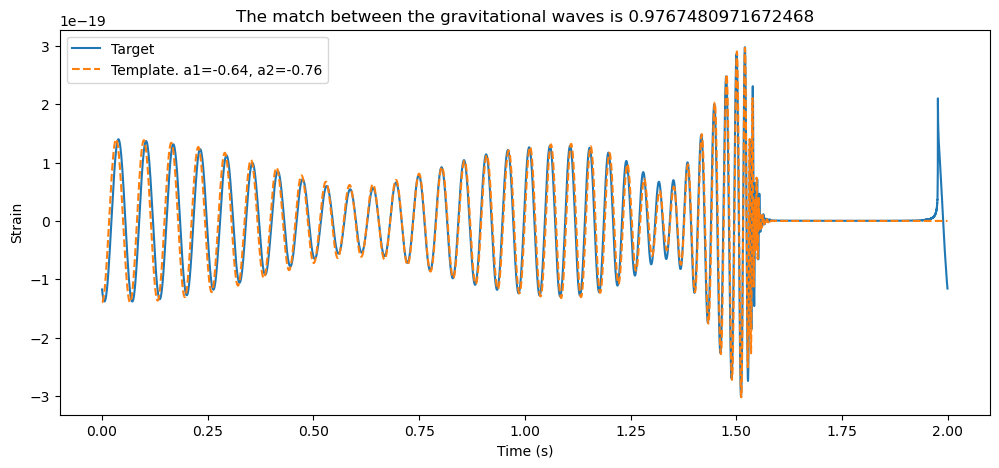

In [27]:
hp_template = []
hc_template = []
time_template = []
 
all_match_for_plot = []
all_spin1x_for_plot = []
all_spin1y_for_plot = []
match = 0
for spin1x in spin1x_template:
    for spin1y in spin1y_template:

        if (spin1x**2+spin1y**2)<1:

            hp, hc, time = simulationTD_IMRPhenomTPHM(mass1_template, mass2_template, r_template, delta_T_template, f_min_template, f_ref_template,
                                                    (spin1x, spin1y, 0), (0, 0, 0))
            # Convert the data obtained from a numpy array to a PyCBC TimeSeries
            hp = TimeSeries(hp, delta_t=delta_T_template) 

            # Computation of the Match
            match_new, Index_new, delta_phi_new = perform_match(hp_target, hp, f_lower = f_min_template, f_high = f_max_template, return_phase = True)
            
            all_match_for_plot.append(match_new)
            all_spin1x_for_plot.append(spin1x)
            all_spin1y_for_plot.append(spin1y)

            if match_new > match:
                match, Index, delta_phi = match_new, Index_new, delta_phi_new
                spin1x_FF = spin1x
                spin1y_FF = spin1y
                hp_FF = hp 
                hc_FF = hc
                time_FF = time 


# Waveforms Coaligned 
h1_aligned, h2_aligned = coalign_waveforms(hp_target, hp_FF)


print(f"The nearest match is {match}, using spins of {spin1x_FF} and {spin1y_FF} respectively")

# Plot of the coaligned waveforms
plt.figure(figsize=(12, 5))
plt.plot(h1_aligned.sample_times, h1_aligned, label = f'Target')
plt.plot(h2_aligned.sample_times, h2_aligned, label = f'Template. a1={spin1x_FF}, a2={spin1y_FF}', linestyle='dashed')
plt.title(f'The match between the gravitational waves is {match}')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.show()

/tmp/ipykernel_18271/1741528185.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  angle.append(math.atan(all_spin1y_for_plot[n]/all_spin1x_for_plot[n]))
/tmp/ipykernel_18271/1741528185.py:6: RuntimeWarning: invalid value encountered in scalar divide
  angle.append(math.atan(all_spin1y_for_plot[n]/all_spin1x_for_plot[n]))


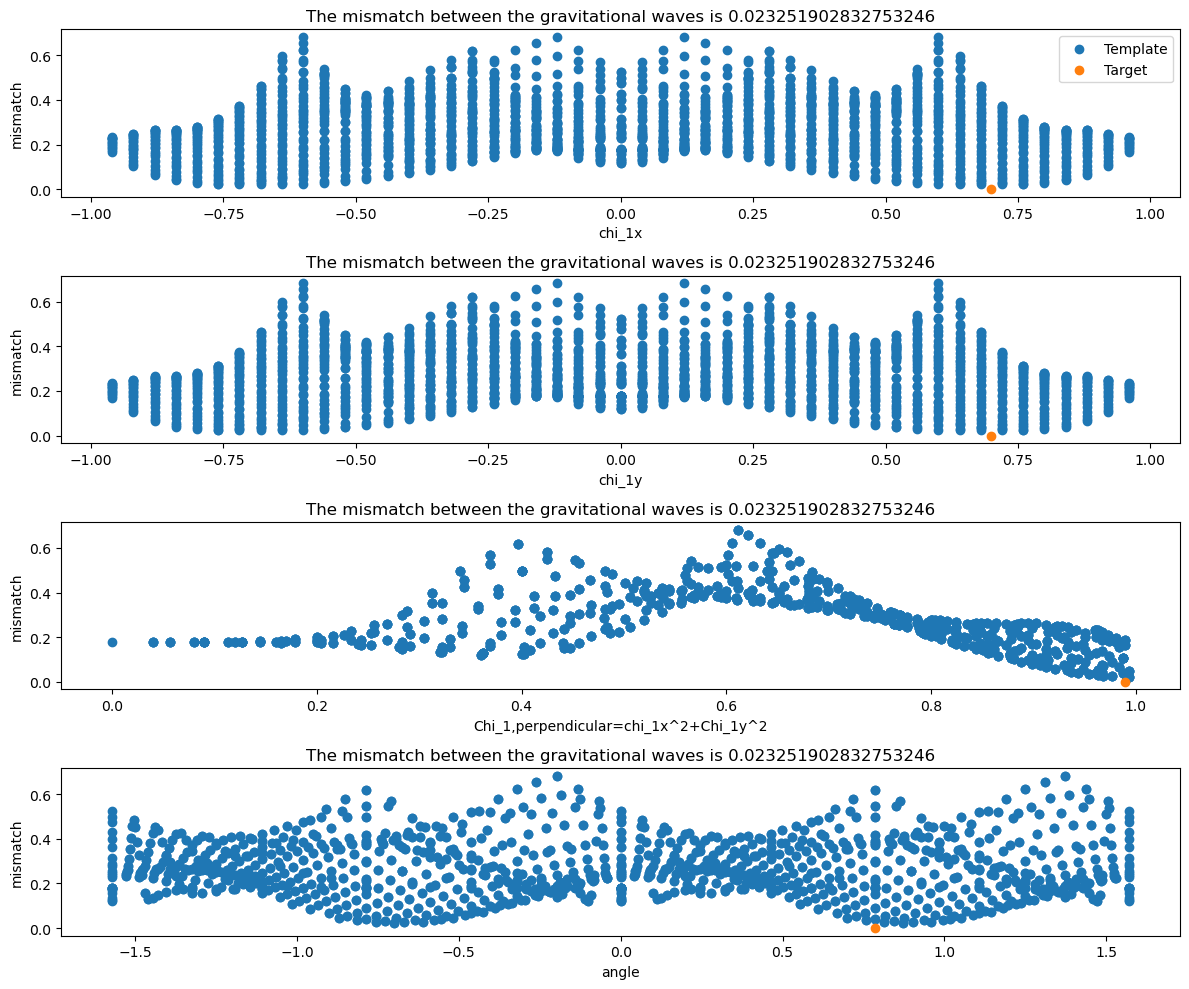

In [ ]:
modulus = []
angle = []
all_mismatch_for_plot= []
for n in range(len(all_spin1x_for_plot)):
    modulus.append(math.sqrt(all_spin1x_for_plot[n]**2+all_spin1y_for_plot[n]**2))
    angle.append(math.atan(all_spin1y_for_plot[n]/all_spin1x_for_plot[n]))
    all_mismatch_for_plot.append(1-all_match_for_plot[n])

modulus = np.array(modulus)
all_mismatch_for_plot = np.array(all_mismatch_for_plot)



# Plot of the coaligned waveforms
plt.figure(figsize=(12,10))
plt.subplot(4, 1, 1)
plt.scatter(all_spin1x_for_plot, np.array(all_mismatch_for_plot), label = f'Template')
plt.scatter(spin1_target[0],0, label = f'Target')
plt.title(f'The mismatch between the gravitational waves is {1-match}')
plt.xlabel('chi_1x')
plt.ylabel('mismatch')
plt.legend()

plt.subplot(4, 1, 2)
plt.scatter(all_spin1y_for_plot, np.array(all_mismatch_for_plot), label = f'Template')
plt.scatter(spin1_target[1],0, label = f'Target')
plt.title(f'The mismatch between the gravitational waves is {1-match}')
plt.xlabel('chi_1y')
plt.ylabel('mismatch')

modulus_target=math.sqrt(spin1_target[0]**2+spin1_target[1]**2)

plt.subplot(4, 1, 3)
plt.scatter(modulus, np.array(all_mismatch_for_plot), label = f'Template')
plt.scatter(modulus_target,0, label = f'Target')
plt.title(f'The mismatch between the gravitational waves is {1-match}')
plt.xlabel('Chi_1,perpendicular=sqrt(chi_1x^2+Chi_1y^2)')
plt.ylabel('mismatch')

angle_target = math.atan(spin1_target[1]/spin1_target[0])

plt.subplot(4, 1, 4)
plt.scatter(angle, np.array(all_mismatch_for_plot), label = f'Template')
plt.scatter(angle_target,0, label = f'Target')
plt.title(f'The mismatch between the gravitational waves is {1-match}')
plt.xlabel('angle')
plt.ylabel('mismatch')

plt.tight_layout()
plt.show()